<a href="https://colab.research.google.com/github/Arturo-Granados/Implementaci-n-de-modelos-de-Ml-en-una-API-con-Django-Rest/blob/main/parte3_bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#UCI ML Drug Review dataset
link: https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018

#Objetivo

Puedes predecir la condicion a partir de la columana review?


#Setup

In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
import joblib


from nltk import word_tokenize
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t

import matplotlib.pyplot as plt
#from google.colab import drive

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers

#Importando el dataset

In [3]:
#Importando Kaggle
!pip install kaggle 

In [4]:
#Api token para acceder a los datos
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artu######","key":"##########678f7c5d7d6e"}'}

In [5]:
#Directorio acctual
!pwd

/content


In [6]:
#Configuración del directorio
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [7]:
#Descarga de los datos 
!kaggle datasets download -d jessicali9530/kuc-hackathon-winter-2018


 59% 24.0M/40.7M [00:00<00:00, 130MB/s] 
100% 40.7M/40.7M [00:00<00:00, 150MB/s]


#Exatraccion de los archivos csv

In [8]:
from zipfile import ZipFile 
#Función para extraer archivos de un archivo Zip
def open_zipfile(file_name):
  with ZipFile(file_name, 'r') as zip:
    
    zip.printdir()
    zip.extractall()
  

In [9]:
#Extracción de los datos 
open_zipfile("kuc-hackathon-winter-2018.zip")

File Name                                             Modified             Size
drugsComTest_raw.csv                           2019-10-11 19:26:30     27637580
drugsComTrain_raw.csv                          2019-10-11 19:26:34     82990470


#Datasets

In [10]:
 # Lectura de los archivos csv
test_set = pd.read_csv('drugsComTest_raw.csv')

train_set = pd.read_csv('drugsComTrain_raw.csv')

In [11]:
#seleccionando las columnas "review" y "condition" de los datasets
train_set= train_set[['review', 'condition']]

In [12]:
test_set= test_set[['review', 'condition']]

#Preprocesamiento

##Preprocesamiento de las columnas 

In [13]:
#Visualización del dataframe
train_set.head()

,review,condition
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",Opiate Dependence


In [14]:
#Dataframe con condiciones y su frecuencia
count_df = train_set[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)

In [15]:
#Visualizaación de la frecuencia de las condiciones
count_df.head()

,condition,review
165,Birth Control,28788
262,Depression,9069
594,Pain,6145
125,Anxiety,5904
80,Acne,5588


In [16]:
#Selección de las condiciones más comunes
target_conditions = count_df[count_df['review']>3000]['condition'].values

In [17]:
#Visualización de las condiciones más comunes
target_conditions

array(['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne',
       'Bipolar Disorde', 'Insomnia', 'Weight Loss', 'Obesity', 'ADHD'],
      dtype=object)

In [18]:
#Función para limpiar la columna condition
def condition_parser(condition):
    if condition in target_conditions:
        return condition
    else:
        return "OTHER"

In [19]:
#Limpieza de la columna condition del trainset
train_set['condition'] = train_set['condition'].apply(condition_parser) 

In [20]:
#Limpieza de la columna condition del testset
test_set['condition'] = test_set['condition'].apply(condition_parser) 

In [21]:
#Visualización de los datos preprocesados
train_set.head()

,review,condition
0,"""It has no side effect, I take it in combinati...",OTHER
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",OTHER


In [22]:
test_set.head()

,review,condition
0,"""I&#039;ve tried a few antidepressants over th...",Depression
1,"""My son has Crohn&#039;s disease and has done ...",OTHER
2,"""Quick reduction of symptoms""",OTHER
3,"""Contrave combines drugs that were used for al...",Weight Loss
4,"""I have been on this birth control for one cyc...",Birth Control


In [23]:
#Eliminamos los valores other 
train_set = train_set[train_set['condition']!='OTHER']

In [24]:
test_set = test_set[test_set['condition']!='OTHER']

In [25]:
#Trainset limpio de condiciones con frecuencia baja
train_set

,review,condition
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
7,"""Abilify changed my life. There is hope. I was...",Bipolar Disorde
9,"""I had been on the pill for many years. When m...",Birth Control
...,...,...
161277,"""I started taking this medication 10 years ago...",Insomnia
161283,"""I was in a very bad place at the time I start...",Bipolar Disorde
161286,"""This is the third med I&#039;ve tried for anx...",Depression
161287,"""I was super against taking medication. I&#039...",Anxiety


In [26]:
#testset limpio de condiciones con frecuencias baja
test_set

,review,condition
0,"""I&#039;ve tried a few antidepressants over th...",Depression
3,"""Contrave combines drugs that were used for al...",Weight Loss
4,"""I have been on this birth control for one cyc...",Birth Control
6,"""I&#039;ve had the copper coil for about 3 mon...",Birth Control
9,"""I was on this pill for almost two years. It d...",Birth Control
...,...,...
53759,"""I was on Microgestin for about 3 years. Over ...",Birth Control
53760,"""I started taking Apri about 7 months ago. My ...",Birth Control
53762,"""I&#039;ve been taking Lexapro (escitaploprgra...",Anxiety
53763,"""I&#039;m married, 34 years old and I have no ...",Birth Control


In [27]:
train_set.condition.value_counts()

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

In [28]:
test_set.condition.value_counts()

Birth Control      9648
Depression         3095
Pain               2100
Anxiety            1908
Acne               1847
Bipolar Disorde    1380
Weight Loss        1248
Insomnia           1231
Obesity            1189
ADHD               1126
Name: condition, dtype: int64

##Limpieza de texto

In [29]:
#Diccionario de contracciones 
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
                    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is",
                    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                    "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would",
                    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


In [30]:
joblib.dump(contraction_dict, 'contraction_dict.pkl')

['contraction_dict.pkl']

In [31]:
#Limpieza de texto

import re
#Limpieza de texto
#Funcion para limpiar text
def clean_text(review): 
   
   review = re.sub('[^a-zA-Z]', ' ', review) # Eliminación de cadenas de strings extrañas
   review = review.lower() #Conversión a minusculas 
   return review

In [32]:
#Función para sustituir contracciones
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)


In [33]:
# Ejemplo
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [34]:
# Limpieza de texto
train_set['review'] = train_set['review'].apply(clean_text)
test_set['review'] = test_set['review'].apply(clean_text)

In [35]:
# Limpieza de contracciones
train_set["review"] = train_set["review"].apply(replace_contractions)
test_set['review'] = test_set['review'].apply(replace_contractions)

In [36]:
#Separaión de los datos en variables x y Y
train_X = train_set['review']
test_X = test_set['review']
train_y = train_set['condition']
test_y = test_set['condition']

##Tokenization

In [37]:
#Parametros basicos

embed_size = 300 # tamaño de los vectores de embedig
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # maximo de palabras por review

'batch_size = 512 # tamaño del batch\nn_epochs = 5 # número de iteraciones\nn_splits = 5 # número de K-fold Splits\nSEED = 42 #semilla para evitar la aleatoriedad\ndebug = 0'

In [38]:
## Tokenization de los reviews
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Aplicación de sentences pad
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [39]:
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

In [40]:
train_X 

array([[   0,    0,    0, ...,    3,  212,  315],
       [   0,    0,    0, ...,   24, 6400, 7124],
       [   0,    0,    0, ...,   21,    3,  376],
       ...,
       [   0,    0,    0, ...,    2,  817, 1440],
       [   0,    0,    0, ...,   94,  196,   32],
       [   0,    0,    0, ...,    3,  800,  129]], dtype=int32)

In [41]:
test_X

array([[   0,    0,    0, ...,   38,  714,   17],
       [   0,    0,    0, ..., 1521,   11,  498],
       [   0,    0,    0, ...,  934,  439,  160],
       ...,
       [   0,    0,    0, ...,  160,   13,  173],
       [   0,    0,    0, ...,   14,  326,  221],
       [   0,    0,    0, ...,   64,  464,   82]], dtype=int32)

In [42]:
#Codificando la variable Y
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y.values)
test_y = encoder.transform(test_y.values)

In [43]:
encoder.classes_

array(['ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde', 'Birth Control',
       'Depression', 'Insomnia', 'Obesity', 'Pain', 'Weight Loss'],
      dtype=object)

In [44]:
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

#Descarga de los Embeddings

In [45]:
#Importando glove
!kaggle datasets download -d takuok/glove840b300dtxt

 99% 2.06G/2.08G [00:14<00:00, 119MB/s]
100% 2.08G/2.08G [00:14<00:00, 155MB/s]


In [46]:
#Extracción del archivo
open_zipfile("glove840b300dtxt.zip")

File Name                                             Modified             Size
glove.840B.300d.txt                            2019-09-25 20:42:48   5646239124


In [47]:
#Carga de glove y matriz de embedding
def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [48]:
embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
joblib.dump(embedding_matrix, 'embedding_matrix.pkl')

['embedding_matrix.pkl']

#Modelo - BiLSTM con Pytorch 

In [50]:
####### Modelo BiLSTM ########
class BiLSTM(nn.Module):
    
    def __init__(self):
        #Metodo super
        super(BiLSTM, self).__init__()
        #Tamaño de la capa oculta
        self.hidden_size = 64
        #Taza Dropout
        drp = 0.1
        #Número de clases
        n_classes = len(encoder.classes_)
        #capa Embeddings
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        #Capa BiLSTM
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        #Capa lineal
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        #Función RELU
        self.relu = nn.ReLU()
        #Capa dropout
        self.dropout = nn.Dropout(drp)
        #output
        self.out = nn.Linear(64, n_classes)


####### forward #######

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out
        

##Entrenamiento

In [53]:
######## parametros #######

# tamaño del batch
batch_size = 500
#Número de epocas
n_epochs = 9
#instancia del modeloBiLSTM
model = BiLSTM()
#Función de perdida
loss_fn = nn.CrossEntropyLoss(reduction='sum')
#Optimizador
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
#Conección con la GPU
model.cuda()

######## tensores #########

# Cargando los train y test seets en la memoria cuda
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# creacion de los Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

######### data loaders ######

# Creación de los Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)


#historial de entrenamiento
train_loss = []
valid_loss = []

#primer buble (itera las epocas de entrenamiento)
for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    avg_loss = 0.1  

    #segundo bucle, itera sobre los batchs
    for i, (x_batch, y_batch) in enumerate(train_loader):
        #Predicción
        y_pred = model(x_batch)
        #Calculo de la funcion de perdida
        loss = loss_fn(y_pred, y_batch)
        #Optinizador
        optimizer.zero_grad()
        #Retropropagación de error
        loss.backward()
        optimizer.step()
        #Taza de perdida
        avg_loss += loss.item() / len(train_loader)

    #Evaluación
    #Fijamos el modelo para validar la configuración
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(encoder.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        #Predicción
        y_pred = model(x_batch).detach()
        #Taza de perdidad
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # Guardando las predicciones
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Checando la precisión
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/9 	 loss=740.0681 	 val_loss=427.3712  	 val_acc=0.6801  	 time=33.46s
Epoch 2/9 	 loss=332.5265 	 val_loss=248.8227  	 val_acc=0.8165  	 time=34.04s
Epoch 3/9 	 loss=231.8997 	 val_loss=200.9630  	 val_acc=0.8516  	 time=35.27s
Epoch 4/9 	 loss=197.7113 	 val_loss=186.8876  	 val_acc=0.8623  	 time=35.99s
Epoch 5/9 	 loss=180.9367 	 val_loss=176.2869  	 val_acc=0.8703  	 time=37.00s
Epoch 6/9 	 loss=166.7194 	 val_loss=166.8749  	 val_acc=0.8769  	 time=37.91s
Epoch 7/9 	 loss=155.7625 	 val_loss=162.4691  	 val_acc=0.8784  	 time=38.69s
Epoch 8/9 	 loss=147.1088 	 val_loss=159.4496  	 val_acc=0.8801  	 time=39.00s
Epoch 9/9 	 loss=139.5625 	 val_loss=155.3842  	 val_acc=0.8840  	 time=38.82s


In [54]:
pip install scikit-plot

In [55]:
#Gráfica de perdida respecto en cada epoca
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Perdida respecto en cada epoca")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='entrenamiento')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validación')
    plt.xlabel('número de epoca', fontsize=12)
    plt.ylabel('perdida', fontsize=12)
    plt.legend(loc='best')

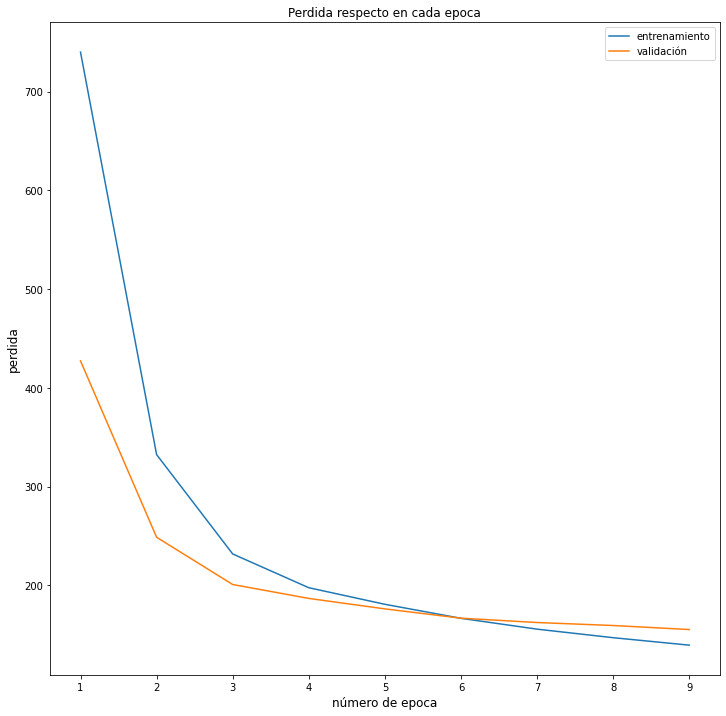

In [56]:
plot_graph(n_epochs)

In [ ]:
#Gráfica de perdida respecto en cada epoca
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Perdida respecto en cada epoca")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='entrenamiento')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validación')
    plt.xlabel('número de epoca', fontsize=12)
    plt.ylabel('perdida', fontsize=12)
    plt.legend(loc='best')

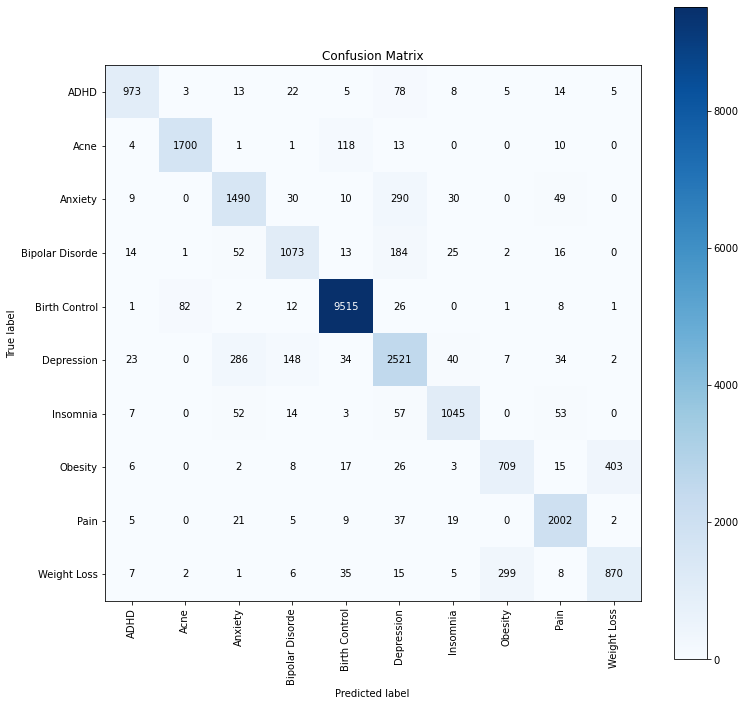

In [57]:
#Matriz de confucion
import scikitplot as skplt
y_true = [encoder.classes_[x] for x in test_y]
y_pred = [encoder.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

##Guardando el modelo

In [58]:
#Guardando el modelo
torch.save(model.state_dict(),'bilstm_model_state_dict')

##Predicciones

In [59]:
model = BiLSTM()

In [60]:
state_dict = torch.load('bilstm_model_state_dict')

In [61]:
# Apply the state dictionary to the model
model.load_state_dict(state_dict)

<All keys matched successfully>

In [62]:
def predict_single(review):    
    
    # lipieza de texto
    review =  clean_text(review)
    # limpieza de contracciones 
    review = replace_contractions(review)
    # tokenizer
    review = tokenizer.texts_to_sequences([review])
    # pad
    review= pad_sequences(review, maxlen=maxlen)
    # creación de torch dataset
    review = torch.tensor(review, dtype=torch.long)
    # predicción
    pred = model(review).detach()
    #fincion softmax
    pred = F.softmax(pred).cpu().numpy()
    #fincion argmax
    pred = pred.argmax(axis=1)

    pred = encoder.classes_[pred]
    return pred[0]

In [63]:
#Texto de prueba 
x = " About two months ago i had to switch from lolestrin fe to microgestin due to my insurance and pharmacy  since starting Microgestin ive noticed insane bloating and nausea and weird discharge  while on lolestrin  my periods consisted of spotting and average side effects  nothing too serious  but after one month of micro i got my period and it was heavy and the cramping was so painful ihad to leave my class  ive also noticed ive developed bad depression and my mood swings are very intense  my anxiety is bad and my sex drive is very low if not nonexistent anymore  it helped with my acne but i      m a lot more paranoid about getting pregnant than i was on lolestrin  i      m going to be talking to my doctor about possibly getting the shot  "

In [64]:
#Predicción
predict_single(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


'Birth Control'